<a href="https://colab.research.google.com/github/kolmar7/rdf/blob/main/RDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Radial distribution function

Maria Kolonsky 2025

v.0.2.3

In [2]:

from urllib.request import urlopen
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET



## Parse XML datafile for $(x, y)$ points

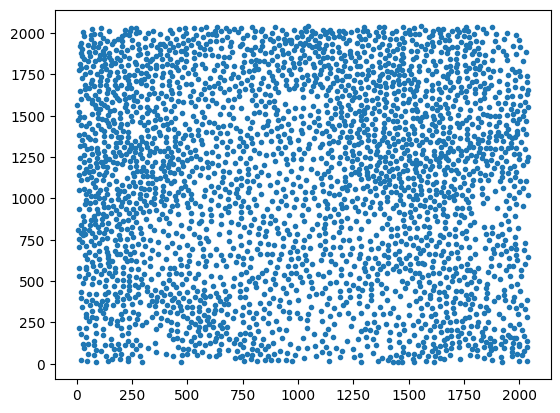

In [3]:
url = 'https://raw.githubusercontent.com/kolmar7/rdf/refs/heads/main/HaCaT%40pla-gel-CPNW%40PMMA(11x11%2Cx20)_2022-05-30_CellCounter_tile_x001_y002%20(1).xml'
#парсинг XML
def parsing_xml(xml_path: str, marker_type: int = 1):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    xc, yc = [], []
    for mtype in root.findall(".//Marker_Type"):
        t = mtype.findtext("Type")
        if not t or int(t.strip()) != marker_type:
            continue
        for m in mtype.findall(".//Marker"):
            x = m.findtext("MarkerX")
            y = m.findtext("MarkerY")
            if x and y:
                xc.append(int(x)); yc.append(int(y))
    return np.asarray(xc, dtype=np.int64), np.asarray(yc, dtype=np.int64)


#запуск
resp = urlopen(url, timeout=30)
X, Y = parsing_xml(resp, marker_type=1)

W = int(X.max()) + 1
H = int(Y.max()) + 1

# total square
S = W * H

N =  X.size




plt.scatter(X, Y, marker='.')

## Using module `numpy` to calculate number of area of intersection of a ring and rectangle

In [4]:
def calculate_circle_area(i, j, r):
    """
    Количество пикселей (целочисленных координат) внутри круга
    (yy - i)^2 + (xx - j)^2 <= r^2 с учётом границ изображения H×W.
    i — индекс строки (y), j — индекс столбца (x). 0-based.
    """

    # вертикальные границы круга, обрезанные окном
    y0 = max(0, i - r)
    y1 = min(H - 1, i + r)
    if y0 > y1:
        return 0

    # расстояния по вертикали от центра до каждой строки в пределах круга
    dy = np.arange(y0, y1 + 1, dtype=np.int64) - i
    # горизонтальный полуразброс (целый) для каждой строки
    # (сколько колонок вправо/влево от j попадает в круг)
    xrad = np.floor(np.sqrt((r * r) - (dy * dy))).astype(np.int64)

    # для каждой строки находим допустимый интервал колонок в окне [0, W-1]
    left  = np.maximum(0, j - xrad)
    right = np.minimum(W - 1, j + xrad)

    # длина интервала по колонкам (если right<left, длина 0)
    counts = np.maximum(0, right - left + 1)

    return int(counts.sum())

def calculate_ring_area(i, j, r, dr):
  return calculate_circle_area(i, j, r+dr) - calculate_circle_area(i, j, r)

i, j = 100, 100
r, dr = 200, 30
%timeit calculate_ring_area(i, j, r, dr)

59.7 µs ± 14 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Using module `numpy` to calculate number of points inside the ring

In [5]:
def count_points(cx, cy, r, deltar):
  distance2 = (X - cx)*(X - cx) + (Y - cy)*(Y - cy)
  r2 = r*r
  rdr2 = (r + deltar) * (r + deltar)
  mask = (distance2 >= r2) & (distance2 <= rdr2)
  count = np.count_nonzero(mask)
  return count

# пример
%timeit count_points(100, 100, 2000, 30)


25.8 µs ± 1.32 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Find density as number of points to square of intersection

In [6]:
def density(cx, cy, r, deltar):
  count  = count_points(cx, cy, r, deltar)
  relative_count = count / N
  square = calculate_ring_area(cx, cy, r, deltar)
  relative_square = square / S
  if square == 0:
    rho = 0
  else:
    rho = count / N  * S / square
  return rho

#density = np.vectorize(density)

# пример
%timeit density(cx=100, cy=100, r=200, deltar=30)

70.3 µs ± 1.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Sweep for all possible radius averaged density




/tmp/ipython-input-2240673710.py:18: RuntimeWarning: invalid value encountered in sqrt
  xrad = np.floor(np.sqrt((r * r) - (dy * dy))).astype(np.int64)
/tmp/ipython-input-2240673710.py:18: RuntimeWarning: invalid value encountered in cast
  xrad = np.floor(np.sqrt((r * r) - (dy * dy))).astype(np.int64)


CPU times: user 3.41 s, sys: 7.07 ms, total: 3.42 s
Wall time: 3.45 s


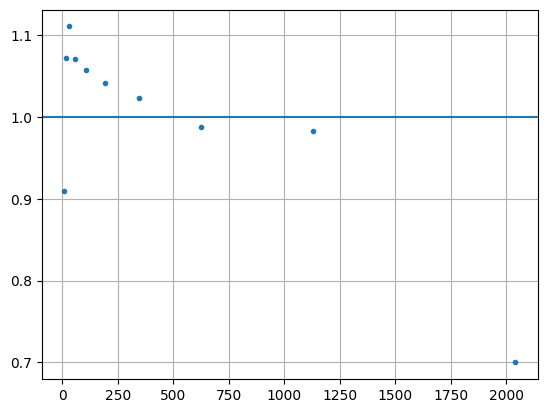

In [7]:
dr = 30
r_max = min(W, H)
r_min = 10

# geometric (logarythmic) spacing makes more steps at near distances and less steps on far distances.
R = np.geomspace(r_min, r_max, num=10)


%time g = [np.mean([density(X[i], Y[i], r, dr) for i in range(N)]) for r in R]


plt.plot(R, g,'.')
plt.axhline(1)
#plt.xlim(0, 1400)
plt.grid()

### The same for uniform distribution

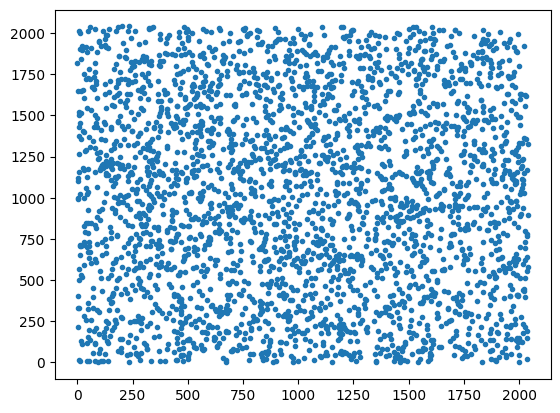

In [8]:
rng = np.random.default_rng(seed=123)
Xu = rng.uniform(0, W, size=N)
Yu = rng.uniform(0, H, size=N)
plt.scatter(Xu, Yu, marker='.')

In [9]:
%time gu = [np.mean([density(Xu[i], Yu[i], r, dr) for i in range(N)]) for r in R]


/tmp/ipython-input-2240673710.py:18: RuntimeWarning: invalid value encountered in sqrt
  xrad = np.floor(np.sqrt((r * r) - (dy * dy))).astype(np.int64)
/tmp/ipython-input-2240673710.py:18: RuntimeWarning: invalid value encountered in cast
  xrad = np.floor(np.sqrt((r * r) - (dy * dy))).astype(np.int64)


CPU times: user 3.4 s, sys: 3.04 ms, total: 3.4 s
Wall time: 3.43 s


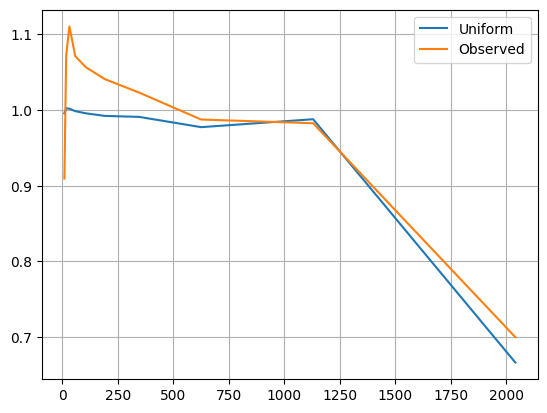

In [10]:
plt.plot(R, gu, label='Uniform')
plt.plot(R, g, label='Observed')
plt.legend()
#plt.xlim(0, 1400)
plt.grid()

## test for a point in the center with growing radius

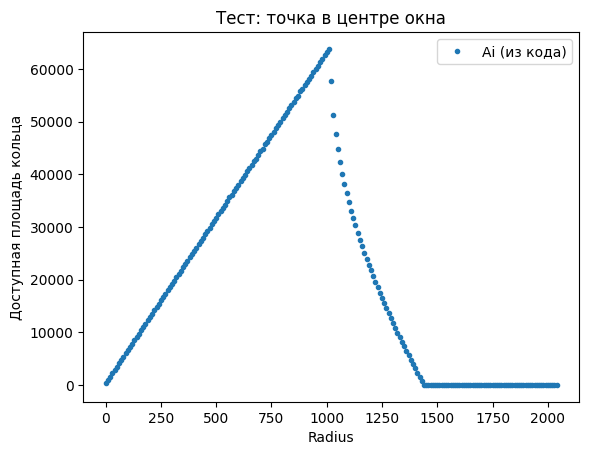

In [11]:
deltar = 10
R = np.arange(0, W, deltar)

xc, yc = W /2, H / 2

Ai = [calculate_ring_area(xc, yc, r, deltar) for r in R]


# график
plt.plot(R, Ai, '.', lw=2, label="Ai (из кода)")
#plt.plot(R, Ai_theory, 'r--', lw=2, label="Ai (аналитика)")
plt.xlabel("Radius")
plt.ylabel("Доступная площадь кольца")
plt.title("Тест: точка в центре окна")
plt.legend()
plt.show()

Равносторонний треугольник

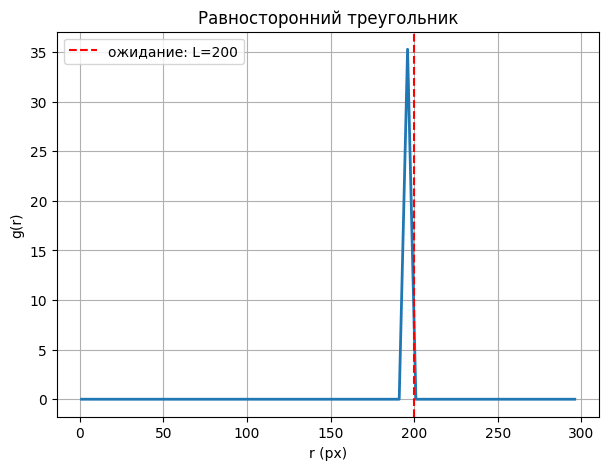

r_peak ≈ 196.0


In [12]:
# равносторонний треугольник
L = 200
X = np.array([0.0, L,   L/2])
Y = np.array([0.0, 0.0, L*np.sqrt(3)/2])
N = X.size

W, H = 500, 500
S = W * H


def density(cx, cy, r, dr):
    count  = count_points(cx, cy, r, dr)
    square = calculate_ring_area(cx, cy, r, deltar)
    if square == 0: return 0.0
    return (count/N) * (S/square)


dr = 5.0
R  = np.arange(1.0, 1.5*L, dr)

g = [np.mean([density(X[i], Y[i], r, dr) for i in range(N)]) for r in R]

plt.figure(figsize=(7,5))
plt.plot(R, g, lw=2)
plt.axvline(L, color='r', ls='--', label=f'ожидание: L={L}')
plt.xlabel('r (px)'); plt.ylabel('g(r)'); plt.title('Равносторонний треугольник')
plt.legend(); plt.grid(True); plt.show()

print("r_peak ≈", R[np.argmax(g)])


Квадрат

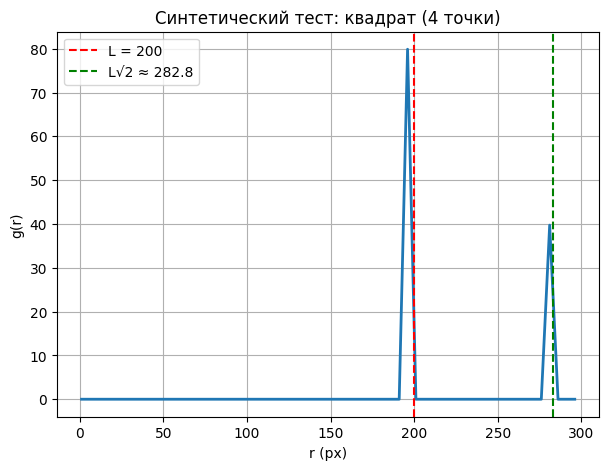

In [13]:
import numpy as np
import matplotlib.pyplot as plt

#квадрат
L = 200.0
margin = 200.0
X = np.array([0, L, L, 0], dtype=float) + margin
Y = np.array([0, 0, L, L], dtype=float) + margin
N = X.size

W, H = 1000, 1000
S = W * H


def count_points(cx, cy, r, dr):
    d2 = (X - cx)**2 + (Y - cy)**2
    return np.count_nonzero((d2 >= r*r) & (d2 <= (r+dr)*(r+dr)))


def density(cx, cy, r, dr):
    cnt = count_points(cx, cy, r, dr)
    sq  = calculate_ring_area(cy, cx, r, dr)
    if sq <= 0:
        return 0.0
    return (cnt / N) * (S / sq)

dr = 5.0
R  = np.arange(1.0, 1.5 * L, dr)


g = [np.mean([density(X[i], Y[i], r, dr) for i in range(N)]) for r in R]

# ожидаемые пики
L1 = L
L2 = L*np.sqrt(2.0)

plt.figure(figsize=(7,5))
plt.plot(R, g, lw=2)
plt.axvline(L1, color='r', ls='--', label=f'L = {L1:.0f}')
plt.axvline(L2, color='g', ls='--', label=f'L√2 ≈ {L2:.1f}')
plt.xlabel('r (px)'); plt.ylabel('g(r)')
plt.title('Синтетический тест: квадрат (4 точки)')
plt.legend(); plt.grid(True); plt.show()




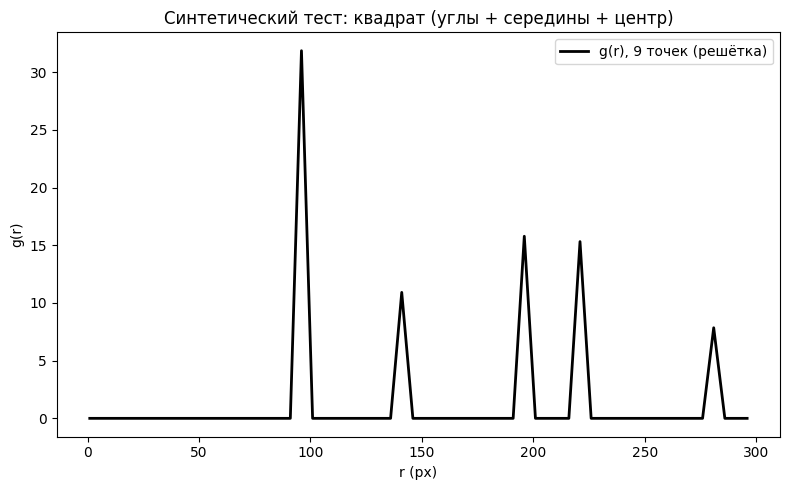

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# --- параметры сетки точек ---
L = 200
margin = 200

x_corners = np.array([0, L, L, 0])
y_corners = np.array([0, 0, L, L])

x_mids = np.array([L/2, L/2, 0, L])
y_mids = np.array([0, L, L/2, L/2])

x_center = np.array([L/2])
y_center = np.array([L/2])

# объединяем все точки
x = np.concatenate([x_corners, x_mids, x_center]) + margin
y = np.concatenate([y_corners, y_mids, y_center]) + margin
N = len(x)

# окно и площадь
W, H = 1000, 1000
S = W * H
def count_points(cx, cy, r, dr):
    d2 = (X - cx)**2 + (Y - cy)**2
    return np.count_nonzero((d2 >= r*r) & (d2 <= (r+dr)*(r+dr)))


def density(cx, cy, r, dr):
    cnt = count_points(cx, cy, r, dr)
    sq  = calculate_ring_area(cy, cx, r, dr)
    if sq <= 0:
        return 0.0
    return (cnt / N) * (S / sq)

dr = 5.0
R  = np.arange(1.0, 1.5 * L, dr)

# --- вычисляем g(r) ---
g = [np.mean([density(x[i], y[i], r, dr) for i in range(N)]) for r in R]

# --- график ---
plt.figure(figsize=(8,5))
plt.plot(R, g, 'k-', lw=2, label="g(r), 9 точек (решётка)")
plt.xlabel("r (px)")
plt.ylabel("g(r)")
plt.title("Синтетический тест: квадрат (углы + середины + центр)")
plt.legend()
plt.tight_layout()
plt.show()
